# IE582 HW 3

#### Nur Gündoğdu

### Task 1

Naive approach with lag 48 and lag 168.

In [14]:
library(data.table)
library(dplyr)
library(ggplot2)
library(glmnet)
library(lubridate)
library(dplyr)
library(tidyr)
library(stats)
library(base)
library(reshape2)
library(tidyverse)

In [99]:
data <- read.csv("C:/Users/n__gu/Desktop/hw3/Consumption.csv")

In [100]:
data$Tuketim <- gsub(".", "", data$Tuketim, fixed=T)
data$Tuketim <- gsub(",", ".", data$Tuketim, fixed=T)
data$Tuketim <- as.numeric(data$Tuketim)

In [101]:
data$Tarih <- dmy(data$Tarih)
data$Saat <- hm(data$Saat)
data <- data %>% mutate(lag48 = lag(Tuketim, 48)) %>% mutate(lag168 = lag(Tuketim, 168))

Split the data into train and test data.

In [161]:
traindata <- data[data$Tarih < "2020-11-01",]
testdata <- data[data$Tarih >= "2020-11-01",]

Mape function:

In [426]:
mape <- function(actual,pred){
           mape <- mean(abs((actual - pred)/actual))*100
           return (mape)
         }

In [294]:
mape_48 <- mape(testdata$Tuketim,testdata$lag48)
mape_48

[1] 7.789204

In [295]:
mape_168 <- mape(testdata$Tuketim,testdata$lag168)
mape_168

[1] 3.453669

MAPE for lag 48 is 7.79, and for lag 168 3.45. We observe that MAPE for lag 168 is much lower and we can comment that lag 168 performs better for the naive approach than lag 48.
We observe that the hour on a day of the week gives better results than predicting with two days prior's data. There is a seasonality weekly, or at least stronger than seasonality of two days.

### Task 2

Linear regression model using long format that includes lag 48 and lag 168.

In [37]:
fit <- lm(Tuketim ~ lag48 + lag168, data = traindata)

In [38]:
summary(fit)


Call:
lm(formula = Tuketim ~ lag48 + lag168, data = traindata)

Residuals:
     Min       1Q   Median       3Q      Max 
-25242.2   -984.2     -0.5   1016.9  16102.6 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 1.574e+03  8.353e+01   18.84   <2e-16 ***
lag48       3.084e-01  3.096e-03   99.60   <2e-16 ***
lag168      6.435e-01  3.094e-03  208.03   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 2392 on 42213 degrees of freedom
  (168 observations deleted due to missingness)
Multiple R-squared:  0.7753,	Adjusted R-squared:  0.7753 
F-statistic: 7.281e+04 on 2 and 42213 DF,  p-value: < 2.2e-16


Coefficients of lag 48 and lag 168, and intercept of the linear regression model:

In [39]:
fit


Call:
lm(formula = Tuketim ~ lag48 + lag168, data = traindata)

Coefficients:
(Intercept)        lag48       lag168  
  1573.6867       0.3084       0.6435  


In [40]:
prediction <- predict(fit,testdata)

In [297]:
mape_b <- mape(prediction, testdata$Tuketim)
mape_b

[1] 4.256718

MAPE for the regression model that uses lag 48 and lag 168 as features is 4.26. This value is lower than MAPE of lag 48, but higher than lag 168. Among the three models so far, lag 168 still performs the best. The reason this model does not perform well might be caused by not differentiating hours.

### Task 3

Linear regression model with hourly seasonality.

In [302]:
traindata$Saat <- as.numeric(traindata$Saat)
testdata$Saat <- as.numeric(testdata$Saat)


In [307]:
byhour <- data.table(time = 0:23, mape=0)

for (i in 0:23){
  fitbyhour <- lm(Tuketim ~ lag48 + lag168, data = traindata[traindata$Saat == i,])
  predictbyhour <- predict(fitbyhour, newdata = testdata[testdata$Saat == i,])
  byhour$mape[i+1] <- mape(testdata[testdata$Saat == i,]$Tuketim, predictbyhour)
}

In [112]:
byhour


time,mape
0,3.266895
1,3.269987
2,3.385306
3,3.190359
4,3.168100
5,3.156634
6,3.131344
7,3.747448
8,4.590345
9,5.299840


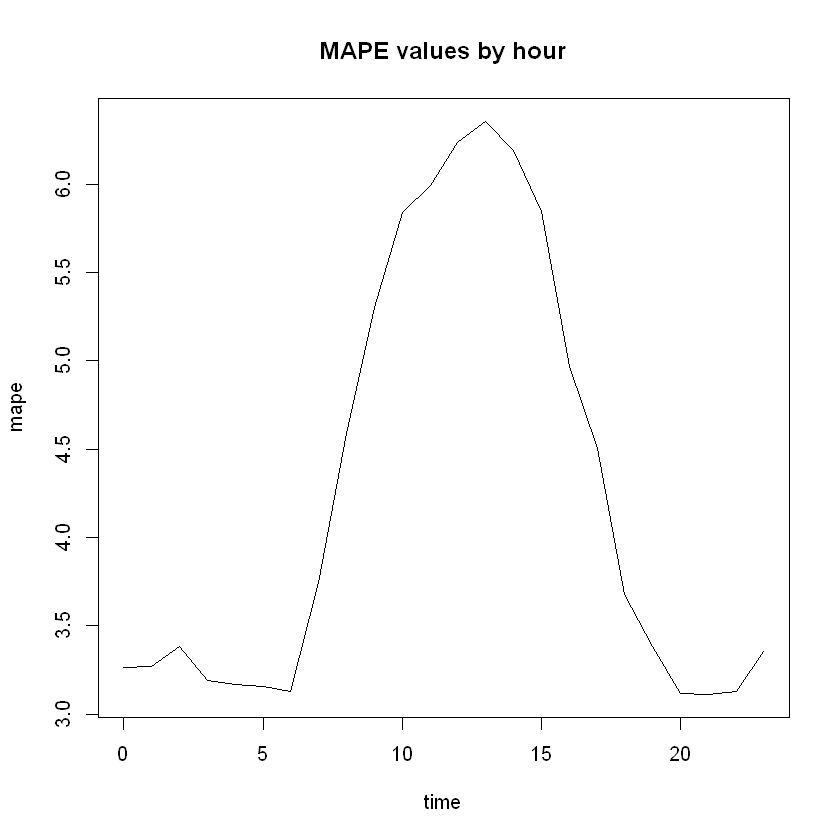

In [316]:
plot(byhour, type="l", main="MAPE values by hour")

From the hourly MAPE values above, we observe that MAPE of nighttime is much lower, and the model performs well for hours from 20.00 to 6.00 in the morning. All the MAPE values for hourly prediction still perfom quite well, with the maximum being 6.35 at 13.00, which is lower than lag 48. As for the comparison with lag 168, whose MAPE was 3.45, the hourly prediction performs better than lag 168 for night hours but performs worse for daytime.

### Task 4

LASSO regression model.

In [113]:
set.seed(1)

In [149]:
traindata$Saat[2068] <- 3
traindata$Tuketim[2068] <- traindata$Tuketim[2069]



In [285]:
data$Saat <- as.numeric(data$Saat)/3600

In [287]:
wideformat <- function(data){
  lag_48 <- dcast(data, Tarih ~ Saat, fun = mean, value.var = 'lag48', fill = 0)
  lag_168 <- dcast(data, Tarih ~ Saat, fun = mean, value.var = 'lag168', fill = 0)
  colnames(lag_48) <- c("Tarih", paste("Lag_day2_hour", 0:23, sep = '_'))
  colnames(lag_168) <- c("Tarih", paste("Lag_day7_hour", 0:23, sep = '_'))
  wide <- data %>%
    left_join(lag_48) %>%
    left_join(lag_168)
  
  data.table(wide[,c(1,2,4:53,3)])
}

In [288]:
wide <- wideformat(data)

Joining, by = "Tarih"
Joining, by = "Tarih"


In [258]:
nwide <- subset( wide, select = -c(3, 4 ) )

In [269]:
train_lasso <- nwide[nwide$Tarih < "2020-11-01", ]
test_lasso <- nwide[nwide$Tarih >= "2020-11-01", ]


In [270]:
train_lasson <- na.omit(train_lasso)


In [323]:
train_lasso

Tarih,Saat,Lag_day2_hour_0,Lag_day2_hour_1,Lag_day2_hour_2,Lag_day2_hour_3,Lag_day2_hour_4,Lag_day2_hour_5,Lag_day2_hour_6,Lag_day2_hour_7,...,Lag_day7_hour_15,Lag_day7_hour_16,Lag_day7_hour_17,Lag_day7_hour_18,Lag_day7_hour_19,Lag_day7_hour_20,Lag_day7_hour_21,Lag_day7_hour_22,Lag_day7_hour_23,Tuketim
2016-01-01,0,NA,NA,NA,NA,NA,NA,NA,NA,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,26277.24
2016-01-01,1,NA,NA,NA,NA,NA,NA,NA,NA,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,24991.82
2016-01-01,2,NA,NA,NA,NA,NA,NA,NA,NA,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,23532.61
2016-01-01,3,NA,NA,NA,NA,NA,NA,NA,NA,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,22464.78
2016-01-01,4,NA,NA,NA,NA,NA,NA,NA,NA,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,22002.91
2016-01-01,5,NA,NA,NA,NA,NA,NA,NA,NA,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,21957.08
2016-01-01,6,NA,NA,NA,NA,NA,NA,NA,NA,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,22203.54
2016-01-01,7,NA,NA,NA,NA,NA,NA,NA,NA,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,21844.16
2016-01-01,8,NA,NA,NA,NA,NA,NA,NA,NA,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,23094.73
2016-01-01,9,NA,NA,NA,NA,NA,NA,NA,NA,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,25202.27


In [271]:
m <- as.matrix(train_lasson[, -c(1,2,51)])
n <- as.matrix(train_lasson[,51])


In [276]:
cv <- cv.glmnet(m,n)

In [326]:
min_lambda <- cv$lambda.min
mape_lasso <- data.frame(Saat = 0:23, MAPE = rep(NA, 24))
for(i in 0:23){
  lasso_model <- glmnet(as.matrix(train_lasson[train_lasson$Saat == i, 3:50]),
                        as.matrix(train_lasson[train_lasson$Saat == i, 51]), alpha = 1,
                        lambda = min_lambda)
  lasso_predictions <- predict(lasso_model, newx = as.matrix(test_lasso[test_lasso$Saat == i, 3:50]))
  mape_lasso$mape[i+1] <- mape(lasso_predictions, as.matrix(test_lasso[test_lasso$Saat == i, 51]))
}


[1] 1.426239 1.575205 1.508097 1.419416 1.515850 1.467137 1.785438 1.914904
 [9] 2.671587 3.663554 4.116574 4.378005 4.667620 4.513814 4.401983 3.935079
[17] 3.072074 2.210922 1.749187 1.645851 1.721369 1.751712 1.644724 1.883512

In [348]:
se1_lambda <- cv$lambda.1se
mape_lasso2 <- data.frame(Saat = 0:23, MAPE = rep(NA, 24))
for(i in 0:23){
  lasso_model2 <- glmnet(as.matrix(train_lasson[train_lasson$Saat == i, 3:50]),
                        as.matrix(train_lasson[train_lasson$Saat == i, 51]), alpha = 1,
                        lambda = se1_lambda)
  lasso_predictions2 <- predict(lasso_model2, newx = as.matrix(test_lasso[test_lasso$Saat == i, 3:50]))
  mape_lasso2$mape[i+1] <- mape(lasso_predictions2, as.matrix(test_lasso[test_lasso$Saat == i, 51]))
}

In [351]:
mape_time <- cbind(hour=0:23,mape_min_lambda = mape_lasso[,3],mape_lambda_1se = mape_lasso2[,3])
mape_time

hour,mape_min_lambda,mape_lambda_1se
0,1.426239,1.377162
1,1.575205,1.469706
2,1.508097,1.453665
3,1.419416,1.323906
4,1.515850,1.370935
5,1.467137,1.367502
6,1.785438,1.656712
7,1.914904,1.904195
8,2.671587,2.624200
9,3.663554,3.609683


In [340]:
coef(cv)

$lambda
 [1] 2515.5000341 2292.0299443 2088.4123213 1902.8835267 1733.8365989
 [6] 1579.8073343 1439.4616050 1311.5838034 1195.0663133 1088.8999159
[11]  992.1650486  904.0238402  823.7128539  750.5364743  683.8608826
[16]  623.1085666  567.7533190  517.3156789  471.3587798  429.4845650
[21]  391.3303400  356.5656312  324.8893233  296.0270512  269.7288239
[26]  245.7668586  223.9336083  204.0399637  185.9136157  169.3975625
[31]  154.3487500  140.6368324  128.1430439  116.7591690  106.3866063
[36]   96.9355134   88.3240295   80.4775662   73.3281610   66.8138893
[41]   60.8783275   55.4700647   50.5422570   46.0522222   41.9610697
[46]   38.2333640   34.8368173   31.7420105   28.9221377   26.3527747
[51]   24.0116669   21.8785366   19.9349077   18.1639454   16.5503106
[56]   15.0800266   13.7403586   12.5197030   11.4074871   10.3940774
[61]    9.4706962    8.6293457    7.8627384    7.1642344    6.5277835
[66]    5.9478732    5.4194806    4.9380289    4.4993480    4.0996383
[71]    3.73

49 x 1 sparse Matrix of class "dgCMatrix"
                             1
(Intercept)      4363.52039617
Lag_day2_hour_0    -0.75888332
Lag_day2_hour_1    -0.29387847
Lag_day2_hour_2     0.02910483
Lag_day2_hour_3     .         
Lag_day2_hour_4     0.02579685
Lag_day2_hour_5     0.82212363
Lag_day2_hour_6     0.06810824
Lag_day2_hour_7     0.38577600
Lag_day2_hour_8    -0.00502274
Lag_day2_hour_9    -1.01044888
Lag_day2_hour_10    .         
Lag_day2_hour_11   -0.07778806
Lag_day2_hour_12    .         
Lag_day2_hour_13    0.97458567
Lag_day2_hour_14   -0.43082363
Lag_day2_hour_15    .         
Lag_day2_hour_16    .         
Lag_day2_hour_17    .         
Lag_day2_hour_18    0.05519471
Lag_day2_hour_19    .         
Lag_day2_hour_20    .         
Lag_day2_hour_21    0.19469440
Lag_day2_hour_22    .         
Lag_day2_hour_23    1.10992472
Lag_day7_hour_0     .         
Lag_day7_hour_1     0.04333345
Lag_day7_hour_2     .         
Lag_day7_hour_3     0.03834499
Lag_day7_hour_4    -0.052224

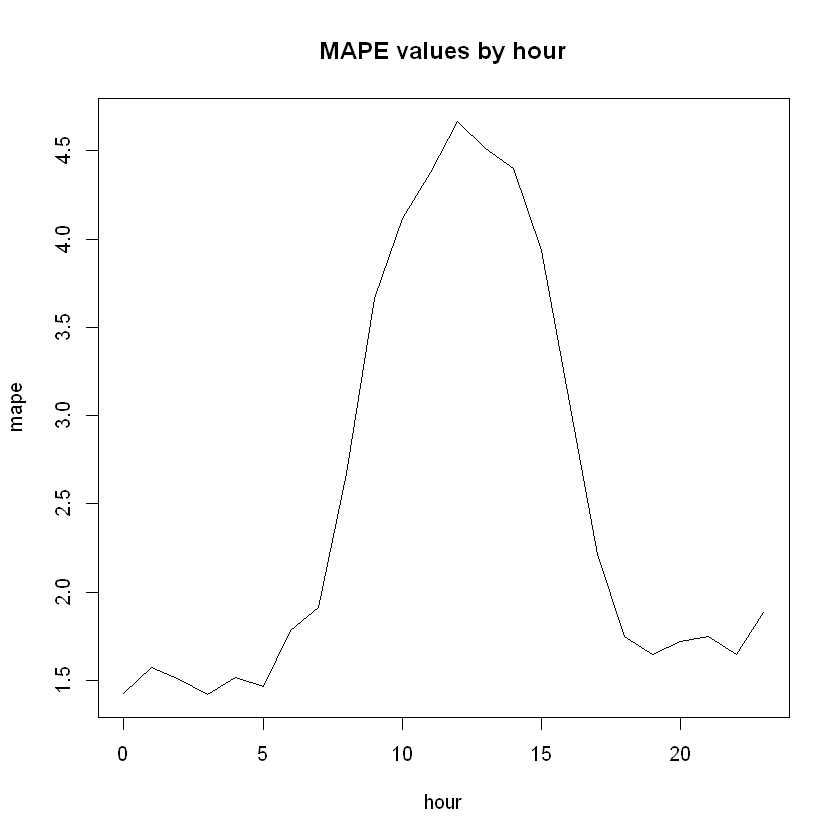

In [331]:
plot(mape_time, type="l", main="MAPE values by hour")

From the plot above, which is very similar to the plot for hourly regression, we observe that this model also performs better for nightly hours than daytime. However, LASSO prediction for all hours performs better than hourly prediction in task b. This model includes both hourly and weekly seasonality, hence perfroms very well.

As for the coefficients of the model, lambda.min is 0.40, and lambda.1se is 2.85. MAPE of model that uses lambda.1se is slightly better than with lambda.min as seen on the table of comparison. Hence, it is better to use lambda.1se. 

Some of the coefficients are negative, which can be interpreted as negative correlation. There are 30 nonzero coefficients and 18 zero coefficient, decreased significantly from the original 48.

### Task 5 (Bonus)

In [358]:
library(CVXR)

In [360]:
cv$lambda.1se

[1] 2.825722

Fused approach with 10-fold cross-validation

In [428]:
lambda1 <- cv$lambda.1se
lambda2 <- 50
beta <- Variable(48)
m_e <- data.table()

train_x <- train_lasson
train_y <- train_lasso
 
set.seed(1)
for(i in 1:10){
    

    for (j in 0:23){
         
      train_fusedx = nwide[Saat == j]
      train_fusedx = as.matrix(train_fusedx[,3:50])
      train_fusedy = as.matrix(nwide[Saat == j , Tuketim])
      
      folds <- cut(seq(1,nrow(train_fusedx)),breaks=10,labels=FALSE)  
        
      testIndexes <- which(folds==i,arr.ind=TRUE)
      testDatax <- train_fusedx[testIndexes, ]
      trainDatax <- train_fusedx[-testIndexes, ]
        
      testDatay <- train_fusedy[testIndexes, ]
      trainDatay <- train_fusedy[-testIndexes, ]
        
        
      obj <- sum_squares(trainDatay - trainDatax %*% beta) +
              lambda2 * sum_squares(beta)+ 
              lambda1 * sum(p_norm(diff(x = beta, differences = 1),1))

      prob <- Problem(Minimize(obj))
      result <- solve(prob)

      beta_list <- result$getValue(beta)
      predicted <- test_fusedx %*% beta_list
      mape_e <- mape(predicted, test_fusedy)
      m_e <- rbind(m_e, data.table(Saat = i, mape = mape_e))

    }
  
}

In [429]:
m_e

Saat,mape
0,1.527979
1,1.711883
2,1.694069
3,1.580582
4,1.677405
5,1.633656
6,1.933184
7,2.070008
8,2.957049
9,3.816892


Given the parameters for lambda, the fused approach worked quite well, but not as well as LASSO. With parameters that are chosen more appropriately, this method might work better than LASSO. Similar to hourly MAPE and LASSO MAPE, it works better for nighttime than daytime.

### Task 6

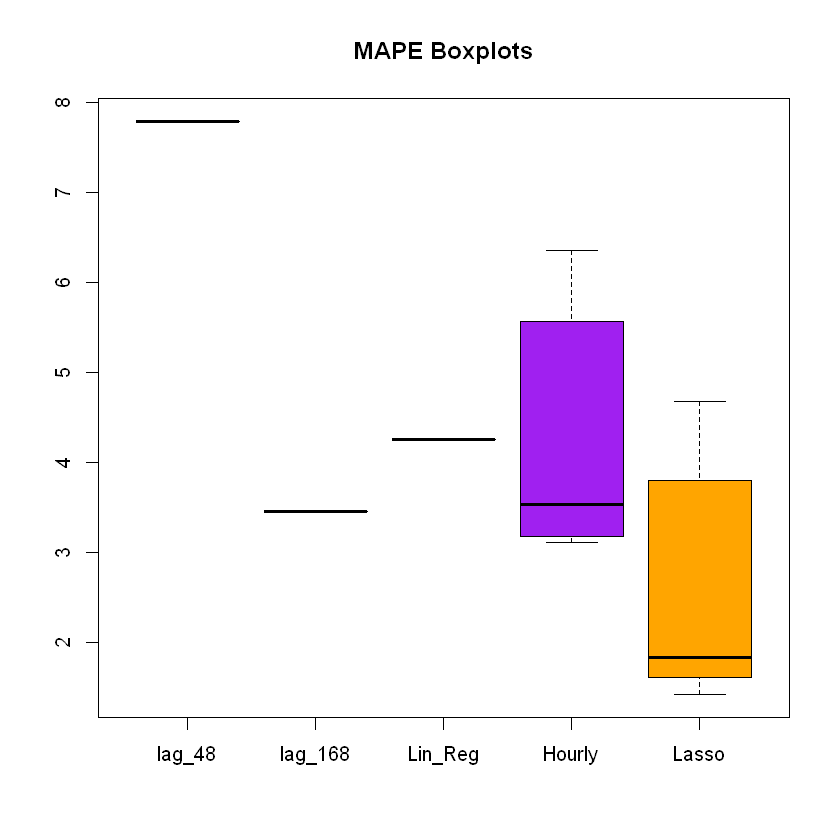

In [292]:
boxplot( mape_48, mape_168, mape_b, byhour$mape, lasso_mape$MAPE, main="MAPE Boxplots", names = c( "lag_48", "lag_168","Lin_Reg","Hourly", "Lasso"), col=c("orange","purple"))

From the boxplot, we observe that Lasso performs the best by measuring with MAPE. The penalization applied in Lasso seems to give the best results. The variances of hourly seasonality approach and LASSO seem similar. Lag 168 performs better than linear regression and slightly better than average of hourly regression. 

The ranking of performances is LASSO, Hourly, lag 168, linear regression and lag 48. Lag 48 does not show weekly seasonality, which explains the performance. 

For this problem, it is appropriate to use LASSO, given the performance, especially for nighttime. It still performs well for daytime.

As for the fused approach in bonus task, Lasso works better but with more appropriate lambda values we might come up with better results than Lasso with fused approach. 